In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

In [2]:
#---------------------------Data Analysis--------------------------------------
#ONLY RUN THIS CELL WHEN NEEDED! Otherwise its unnecessary.
#data file name is in structure of "label_attempt.json" (e.g "0_1.json"), each file contains a list of dictionaries {"MAC":mac, "RSSI":rssi}
#read through all files and create a set of MAC addresses that are in all files
num_labels = 3
num_attempts = 10
mac_set = set()
base_path = "data"
for label in range(num_labels):
    for attempt in range(num_attempts):
        file_name = os.path.join(base_path,str(label) + "_" + str(attempt) + ".json")
        with open(file_name, "r") as f:
            data = json.load(f)
            for item in data:
                item = json.loads(item)
                mac_set.add(item["MAC"])
mac_set = list(mac_set)
print("Number of MAC addresses: ", len(mac_set))
#save mac_set to a file
with open(os.path.join(base_path,"mac_set.txt"), "w") as f:
    for mac in mac_set:
        f.write(mac + "\n")

Number of MAC addresses:  175


In [3]:
#---------------------------Data Preprocessing--------------------------------------
#read mac_set.txt and create a list
mac_set = []
with open(os.path.join(base_path,"mac_set.txt"), "r") as f:
    for line in f:
        mac_set.append(line.strip())

#data training set
data_set = []
#read through all files
for label in range(num_labels):
    for attempt in range(num_attempts):
        file_name = os.path.join(base_path, f"{label}_{attempt}.json")
        try:
            with open(file_name,"r") as f:
                data = json.load(f) #list of dictionary with mac, rssi
                #create a 0 vector with length of mac_set
                vector = np.zeros(len(mac_set))
                #for each mac in data, find its index in mac_set and update the vector
                for item in data:
                    item = json.loads(item)
                    index = mac_set.index(item["MAC"])
                    vector[index] = item["RSSI"]
                #data point = (label, vector)
                data_set.append((label, vector))
        except:
            print("Error in file: ", file_name)

#data_set to dataframe
df = pd.DataFrame(data_set, columns=["label", "vector"])
# print(df)

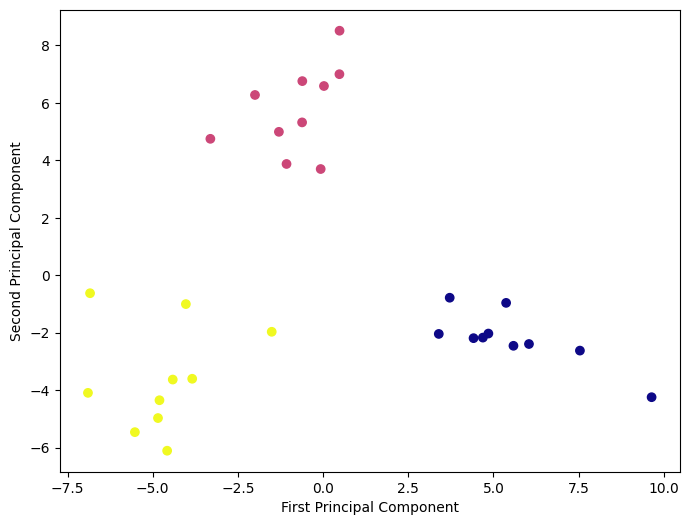

In [4]:
#---------------------------Data Visualization--------------------------------------
#vector is len(mac_set) long, which is a large dimension. So let's use auto encoder to reduce the dimension and visualize the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#standardize the data
scaler = StandardScaler()
vec = df["vector"].values.tolist()
scaled_data = scaler.fit_transform(vec)

#PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

#plot
plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=df["label"], cmap="plasma")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

KNN MSE:  0.6666666666666666


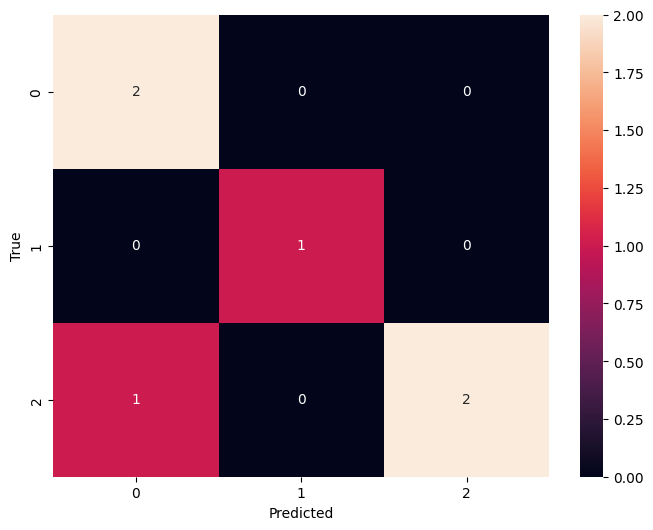

In [7]:
#---------------------------Model Training--------------------------------------
#knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#split data
X = df["vector"].values.tolist()
y = df["label"].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#train knn model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print("KNN MSE: ", mean_squared_error(y_test, pred))


In [ ]:
#---------------------------Predict Visualization--------------------------------------
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
#confusion matrix
cm = confusion_matrix(y_test, pred)
#plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()